# Batch Learning from Bandit Feedback

## Imports

In [ ]:
import math
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model 

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.datasets import load_digits, load_breast_cancer, load_wine, fetch_openml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Utils

In [ ]:
def create_interactions(X: np.ndarray, T: np.ndarray, one_hot_labeler=None) -> tuple:
    if one_hot_labeler is None:
        lb_fit = sklearn.preprocessing.LabelBinarizer().fit(T)
    else:
        lb_fit = one_hot_labeler
    T = lb_fit.transform(T)
    XT = np.zeros(shape=[X.shape[0], X.shape[1] * T.shape[1]]) * np.nan
    cnt = 0
    for i in range(X.shape[1]):
        for j in range(T.shape[1]):
            XT[:,cnt]= X[:, i] * T[:, j]
            cnt += 1
    X_full = np.column_stack((X, T, XT))
    return X_full, lb_fit

## Supervised to Bandit Transform (STBT)

In [ ]:
class STBT:
   
    """
    Performs Supervised to Bandit Conversion for classification 
    datasets. This conversion is generally used to test the limits of 
    counterfactual learning in a well-controlled environment [1,2,3]. 
    
    Parameters
    ----------
    
    train_frac : float, default: 0.50
        It should be between 0.0 and 1.0 and represents the
        proportion of the dataset to include in the train split.
        
    permute : bool, default: False
        Randomly permute the data before the random split between train and test.
    logging_type : str, default: "uniform"
        The type of logging policy. If "uniform", uniform random samples from the 
        labels $y$ to simulate a logging policy. If "biased", the logging policy
        is a stochastic function of the covariates.
        
    sample_frac : float, default: None
        A sample fraction between (0.0,1.0]. This is the sample fraction of the
        training data used to fit the target policy. By default, the full
        training set is used. 
     
    References
    ----------
    
    .. [1] N. Jiang, and  L. Li, Doubly Robust Off-policy Value Evaluation for Reinforcement Learning, 
           Proceedings of Machine Learning Research, 48, 652--661, 2016.
    .. [2] A. Swaminathan and T. Joachims, Batch Learning from Logged Bandit Feedback through 
           Counterfactual Risk Minimization, Journal of Machine Learning Research, 16(52),
           1731--1755, 2015.
    .. [3] A. Swaminathan and T. Joachims, The self-normalized estimator for counterfactual learning, 
           Advances in Neural Information Processing Systems, 28, 16(52), 3231--3239, 2015.
           
    Examples
    --------
    >>> np.random.seed(42)
    >>> X, y = get_data(dataset='ecoli')  
    >>> obj = STBT()
    >>> sample_batch = obj.generate_batch(X, y)
    >>> sample_batch.y_train_logging[0:5]
    array([1, 1, 0, 0, 0]))
    
    """
    
    def __init__(self, train_frac: float = 0.50, permute: bool = False, logging_type: str = 'uniform',
                 sample_frac: float = None):
        self.train_frac = train_frac
        self.permute = permute
        self.logging_type = logging_type
        self.sample_frac = sample_frac
        
    def __repr__(self):
        
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def _validate_input(self):
        if not isinstance(self.train_frac, float) or not (0.0 < self.train_frac < 1.0):
            raise ValueError("`train_frac` should be a float in (0.0,1.0), got %s" % self.train_frac)
            
        if self.sample_frac is not None and self.sample_frac is not (0.0 < self.sample_frac <= 1.0):
            raise ValueError("`sample_frac` should be a float in (0.0,1.0], got %s" % self.sample_frac)

        if self.logging_type not in ['uniform', 'biased']:
            raise ValueError("`logging_type` should be either 'uniform' or 'biased', got %s" % self.logging_type)
    
    def _softmax(self, x, axis=-1):
        
        kw = dict(axis=axis, keepdims=True)
        xrel = x - x.max(**kw)
        exp_xrel = np.exp(xrel)
        p = exp_xrel / exp_xrel.sum(**kw)  
         
        return p
        
         
    def generate_batch(self, X: np.ndarray, y: np.ndarray, **kwargs):
        """Generate Supervised to Bandit batch
        
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y : array of shape (n_samples,)
            Target vector relative to X.
        **kwargs : Arguments passed to fit method in 
                   `sklearn.linear_model.LogisticRegression` class.
        
        Returns
        -------
        X_train : array of shape (n_train_samples, n_features)
        y_train : array of shape (n_train_samples,)
        X_test : array of shape (n_test_samples, n_features)
        y_test : array of shape (n_test_samples,)
        y_train_logging : array of shape (n_train_samples,)
            Logging policy labels on train data
        train_logging_probs : array of shape (n_train_samples, n_classes)     
            Logging policy probabilities on train data
        train_logging_prob : array of shape (n_train_samples,)
            Logging policy probability corresponding to the chosen logging label on train data
        y_train_logging_idx : array of shape (n_train_samples, n_classes)
            Binary matrix with 1s indicating which action was taken by the logging policy in train data
           
        y_test_logging : array of shape (n_test_samples,)
             Logging policy labels on test data
        test_logging_probs : array of shape (n_test_samples, n_classes)   
            Logging policy probabilities on test data
        test_logging_prob : array of shape (n_test_samples,)
            Logging policy probability corresponding to the chosen logging label on test data
       
        y_train_target : array of shape (n_train_samples,)
             Target policy labels on train data
        train_target_prob : array of shape (n_train_samples, n_classes)     
             Target policy probabilities on train data
        train_target_probs : array of shape (n_train_samples,)
            Target policy probability corresponding to the chosen logging label on train data
       
        y_test_target : array of shape (n_test_samples,)
             Target policy labels on test data
        test_target_prob : array of shape (n_test_samples, n_classes)     
             Target policy probabilities on test data
        test_target_probs : array of shape (n_test_samples,)
            Target policy probability corresponding to the chosen logging label on test data
       
        true_target_value_test : float
            True value of Target policy on test data
       
        train_logging_reward : array of shape (n_train_samples,)
            Observed reward of logging policy on train data 
        test_logging_reward : array of shape (n_test_samples,)
            Observed reward of logging policy on test data 
            
        """
        self._validate_input()
        
        self.generate_batch_call = True
        
        self.dual = False
        
        if self.permute:
            permute = np.random.permutation(X.shape[0])
            X = X[permute, :]
            y = y[permute]

        self.X_train, self.X_test, self.y_train, self.y_test = \
            sklearn.model_selection.train_test_split(X, y,
                train_size = self.train_frac) 
            
        n_train_samples, n_features = self.X_train.shape
        n_test_samples = self.X_test.shape[0]

    
        y_train_u = np.unique(self.y_train)
        
        if self.logging_type == 'uniform':

            self.y_train_logging = np.random.choice(y_train_u, size=n_train_samples)  
            self.train_logging_prob = np.repeat(1.0/len(y_train_u), n_train_samples)
            self.train_logging_probs = np.repeat(self.train_logging_prob.reshape(-1,1), len(y_train_u), axis=1)
            self.y_test_logging = np.random.choice(y_train_u, size=n_test_samples)  
            self.test_logging_prob = np.repeat(1.0/len(y_train_u), n_test_samples)
            self.test_logging_probs = np.repeat(self.test_logging_prob.reshape(-1,1), len(y_train_u), axis=1)
            
            self.y_train_logging_idx = np.full((n_train_samples, len(y_train_u)), False, dtype=bool)
            for i in range(n_train_samples):
                self.y_train_logging_idx[i, np.where(y_train_u==self.y_train_logging[i])[0][0]] = True 
        
        else:
            
            W = np.random.normal(0, 1, (n_features, len(y_train_u)))
            lp_train = self.X_train @ W
            lp_test = self.X_test @ W
            self.train_logging_probs = self._softmax(lp_train)
            self.test_logging_probs = self._softmax(lp_test)
            
            self.y_train_logging_idx = np.full((n_train_samples, len(y_train_u)), False, dtype=bool)
            y_test_logging_idx = np.full((n_test_samples, len(y_train_u)), False, dtype=bool)
            
            for sample in range(n_train_samples):
                choice = np.random.multinomial(1, self.train_logging_probs[sample,:], size = 1)[-1]
                self.y_train_logging_idx[sample, :] = choice
            
            for sample in range(n_test_samples):
                choice = np.random.multinomial(1, self.test_logging_probs[sample,:], size = 1)[-1]
                y_test_logging_idx[sample, :] = choice
            
            self.y_train_logging = np.array([y_train_u,]*n_train_samples)[self.y_train_logging_idx]
            self.y_test_logging = np.array([y_train_u,]*n_test_samples)[y_test_logging_idx]
            
            self.train_logging_prob = self.train_logging_probs[self.y_train_logging_idx]
            self.test_logging_prob = self.test_logging_probs[y_test_logging_idx]
            
        if self.sample_frac is not None:
            n_subsamples = math.ceil(self.sample_frac * n_train_samples)
            idx_subsamples = np.random.randint(n_train_samples, size=n_subsamples)
            X_train_subsamples = self.X_train[idx_subsamples, :]
            y_train_subsamples = self.y_train[idx_subsamples]
            if n_subsamples < n_features:
                self.dual=True
            target_policy = sklearn.linear_model.LogisticRegression(**kwargs, dual=self.dual).fit(X_train_subsamples, y_train_subsamples)
       
        else:
            if n_train_samples < n_features:
                self.dual=True
            target_policy = sklearn.linear_model.LogisticRegression(**kwargs, dual=self.dual).fit(self.X_train, self.y_train)
        
        self.train_target_probs = target_policy.predict_proba(self.X_train)
        self.test_target_probs = target_policy.predict_proba(self.X_test)
         
        y_train_target = list()
        train_target_prob = list()
        y_test_target = list()
        test_target_prob = list()
         
        for i in range(n_train_samples):
            y_train_target_i = np.random.choice(y_train_u, size=1, 
                                                 replace=False, p=self.train_target_probs[i,:])[0]
            y_train_target.append(y_train_target_i)
            train_target_prob.append(self.train_target_probs[i, np.where(y_train_u==y_train_target_i)[0][0]])
        self.y_train_target = np.array(y_train_target)
        self.train_target_prob = np.array(train_target_prob)
        
        for i in range(n_test_samples):
            y_test_target_i = np.random.choice(y_train_u, size=1, 
                                                 replace=False, p=self.test_target_probs[i,:])[0]
            y_test_target.append(y_test_target_i)
            test_target_prob.append(self.test_target_probs[i, np.where(y_train_u==y_test_target_i)[0][0]])
        self.y_test_target = np.array(y_test_target)
        self.test_target_prob = np.array(test_target_prob)
        
        self.true_target_value_test = np.mean(1 * (self.y_test == self.y_test_target))
        
        self.train_logging_reward = 1 * (self.y_train == self.y_train_logging)
        self.test_logging_reward = 1 * (self.y_test == self.y_test_logging)
           
        return self

## Off-Policy Evaluation Estimators

In [ ]:
class PolicyEvaluation:
        """
        Performs off-policy evaluation with bandit feedback. 
        
        Parameters
        ----------
        method : str, default: 'ips'.
            The policy evaluation method. The default is 'ips'.
            It should be one of: 'ips' (Inverse Propensity Score), 
            'dm' (Direct Method), 'dr' (Doubly Robust), 'switch'
            (SWITCH estimator).
            
        tau : float, default: 0.001.
            Hyperparameter added to IPS or SWICTH estimator for numerical stability. 
            
            For method='ips', the logging probabilities in the test set get adjusted by
            the max(logging probabilities, tau).
            
            For method = 'switch', when logging probabilities are larger than this parameter,
            the 'dm' estimator is applied, otherwise the 'dr' estimator is applied. 
            
            
        References
        ----------
    
        .. [1] Y. Wang, A. Agarwal and M. Dud\'{\i}k, Optimal and Adaptive Off-policy Evaluation in Contextual Bandits, 
               Proceedings of Machine Learning Research, 70, 3589--3597, 2017.
        .. [2] N. Jiang, and  L. Li, Doubly Robust Off-policy Value Evaluation for Reinforcement Learning, 
               Proceedings of Machine Learning Research, 48, 652--661, 2016.
        .. [3] K{\"u}nzel, S., Sekhon, J., Bickel, P. and Yu, B., Metalearners for estimating heterogeneous 
               treatment effects using machine learning, Proceedings of the National Academy of Sciences, 
               116(10), 4156--4165, 2019. 
               
        Examples
        --------
        >>> np.random.seed(42)
        >>> from blbf.STBT import STBT
        >>> from blbf.PolicyEvaluation import PolicyEvaluation 
        >>> X, y = get_data(dataset='ecoli')
        >>> obj = STBT(train_frac= 0.5)
        >>> data = obj.generate_batch(X, y, max_iter=1000)
        >>> PolicyEvaluation(method='dr').evaluate_policy(data = data)
        0.7241601514218099
        """
    
        def __init__(self, method: str = 'ips', tau: float = 0.001):
            
            self.method = method
            self.tau = tau 
            
            valid_methods = ['ips', 'dm', 'dr', 'switch']
            if self.method not in valid_methods:
                raise ValueError("%s is not a valid method." % self.method)
        
            if self.tau <= 0 or self.tau >1:
                raise ValueError("`tau` must be in the (0, 1) interval, got %s." % self.tau)
                       
        def __repr__(self):
            
            items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
            return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
        
        def evaluate_policy(self, data, clf: str = 'LogisticRegression', **kwargs) -> float:
            """
            Parameters
            ----------
            data : STBT object
                This must be a Supervised to Bandit Transform (STBT) class with fitted 
                `generate_batch` method.
                
            clf : str, default: 'LogisticRegression'
            A sklearn classification estimator. Must be one of 'LogisticRegression', 
            'LogisticRegressionCV', 'RandomForestClassifier', or 'SVC'.
           
            **kwargs : Arguments passed to clf.
    
            Returns
            -------
            float.
              The estimated value of the policy.
        
            """
              
            if not hasattr(data, 'generate_batch_call'):
                raise TypeError("The method `generate_batch` must be called first on the instance: %s." % (data))
                                    
            if self.method == 'ips':
                
                if self.tau is not None:
                    adj_test_logging_prob = np.maximum(self.tau, data.test_logging_prob)  
                
                else:
                    adj_test_logging_prob = data.test_logging_prob
                
                v = np.mean(data.test_logging_reward * (data.y_test_logging == data.y_test_target) / adj_test_logging_prob)
                
            else:
                XY_train, lb_fit = create_interactions(data.X_train, data.y_train_logging)
                m = eval(clf)(**kwargs).fit(XY_train, data.train_logging_reward)
                XY_test_target, _ = create_interactions(data.X_test, data.y_test_target, one_hot_labeler = lb_fit)
                test_target_pred_reward = m.predict_proba(XY_test_target)[:,1]
                
                if self.method in ['dr', 'switch']:
                    XY_test_logging, _ = create_interactions(data.X_test, data.y_test_logging, one_hot_labeler = lb_fit)
                    test_logging_pred_reward = m.predict_proba(XY_test_logging)[:,1]
                    dr_adj = (data.test_logging_reward - test_logging_pred_reward) * \
                                 (data.y_test_logging == data.y_test_target) / data.test_logging_prob
                
                if self.method == 'dm':
                    v = np.mean(test_target_pred_reward) 
                    
                elif self.method == 'dr':
                    v = np.mean(test_target_pred_reward + dr_adj)
                        
                elif self.method == 'switch':
                    switch_indicator = np.array(data.test_logging_prob <= self.tau, dtype=int)
                    switch_estimator_rewards = (1-switch_indicator) * (dr_adj + test_target_pred_reward)
                    switch_estimator_rewards += switch_indicator * test_target_pred_reward
                    v = np.mean(switch_estimator_rewards)
          
            return v

## Sample datasets used in experiments

In [ ]:
def get_data(dataset: str = None, scale: bool = True) -> tuple:
    """Get data (features and labels) used in experiments.
    
    Parameters
    ----------
    
    dataset : str, default: None 
        It should be one of: 'ecoli', 'glass', 'letter-recognition', 
        'lymphography', 'yeast', 'digits', 'breast-cancer', 'wine', or 
        'mnist'.
        
    scale : bool, default: True
        Standardize features by zero mean and unit variance.
        
    Returns
    -------
    
    tuple, length=2 
        tuple containing features-target split of inputs.
        
    References
    ----------
    Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. 
    Irvine, CA: University of California, School of Information and Computer Science.
    
    Examples
    --------
    >>> X, y = get_data(dataset='ecoli')
    >>> X[0,:]
    array([0.49, 0.29, 0.48, 0.5 , 0.56, 0.24, 0.35])
    
    """
    
    if dataset not in ['ecoli', 'glass', 'letter-recognition', 'lymphography', 'yeast', 
                       'digits', 'breast-cancer', 'wine', 'mnist']:
        raise ValueError("Invalid dataset provided.")
    
    if dataset in dataset in ['ecoli', 'glass', 'letter-recognition', 'lymphography', 'yeast']:
        path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/' 
        f = path + dataset + "/" + dataset + ".data"
     
    if dataset in  ['ecoli', 'yeast']:
        df = pd.read_table(f, delim_whitespace=True, header=None)
    elif dataset in [ 'glass', 'letter-recognition', 'lymphography']:
        df = pd.read_csv(f, header=None)
    elif dataset == 'digits':
        df = load_digits()
        X = df.data
        y = df.target
    elif dataset == 'breast-cancer':
        df = load_breast_cancer()
        X = df.data
        y = df.target
    elif dataset == 'wine':
        df = load_wine()
        X = df.data
        y = df.target
        
    if dataset == 'ecoli':
        y = preprocessing.LabelEncoder().fit_transform(df.iloc[:,-1])
        X = df.iloc[:,1:8].values
        
    elif dataset == 'glass':
        y = df.iloc[:,-1].values
        X = df.iloc[:, 1:(df.shape[1]-1)].values
        
    elif dataset in ['letter-recognition', 'lymphography']:
        y = preprocessing.LabelEncoder().fit_transform(df.iloc[:,0])
        X = df.iloc[:, 1:(df.shape[1])].values
     
    elif dataset == 'yeast':
        y = preprocessing.LabelEncoder().fit_transform(df.iloc[:,-1])
        X = df.iloc[:,1:9].values
        
    elif dataset == 'mnist':
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        y = y.astype('int64') 

    if scale==True:
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    return X, y

## Compare the following methods
- IPS: Inverse Propensity Score
- DM: Direct Method (Reward Prediction)
- DR: Doubly Robust
- SWITCH: Switch Estimator

In [ ]:
class ComparePolicyEvaluation:
    
    def __init__(self, B: int = 100, datasets: list = None):
        self.B = B
        self.datasets = datasets
        
    def __repr__(self):
            
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))

    def fit_policies(self, **kwargs) -> pd.DataFrame:
        
        if self.datasets is None:
            self.datasets = ['ecoli', 'glass', 'lymphography', 'yeast', 
                        'digits', 'breast-cancer', 'wine'] # 'letter-recognition'
        dat = list()
        true_value = list()
        ips = list()
        dm = list()
        dr = list()
        switch = list()
        
        for s in self.datasets:
            for b in range(self.B):
                if (b % 10) == 0:
                    print("Sample: %d - Dataset: %s" % (b, s))
                X, y = get_data(dataset=s)
                d = STBT().generate_batch(X, y, max_iter=1000)
                dat.append(s)
                true_value.append(d.true_target_value_test)
                ips.append(PolicyEvaluation(method='ips').evaluate_policy(data = d))
                dm.append(PolicyEvaluation(method='dm').evaluate_policy(data = d, **kwargs))
                dr.append(PolicyEvaluation(method='dr').evaluate_policy(data = d, **kwargs))
                switch.append(PolicyEvaluation(method='switch').evaluate_policy(data = d, **kwargs))
           
        res = pd.DataFrame.from_dict({'dataset':dat, 'true_value':true_value, 'ips':ips,
                                     'dm': dm, 'dr':dr, 'switch': switch})
    
        # Bias
        res['ips_bias'] = res['true_value'].values - res['ips'].values
        res['dm_bias'] = res['true_value'].values - res['dm'].values
        res['dr_bias'] = res['true_value'].values - res['dr'].values
        res['switch_bias'] = res['true_value'].values - res['switch'].values
        
        # Relative risk
        res['ips_rr'] = np.abs((res['true_value'].values - res['ips'].values)/res['true_value'].values)
        res['dm_rr'] = np.abs((res['true_value'].values - res['dm'].values)/res['true_value'].values)
        res['dr_rr'] = np.abs((res['true_value'].values - res['dr'].values)/res['true_value'].values)
        res['switch_rr'] = np.abs((res['true_value'].values - res['switch'].values)/res['true_value'].values)
        
        self.res = res
       
        return self
    
    def get_summary_stats(self):
        
        res_summary = self.res.groupby(['dataset'], as_index=False).agg({
                            'ips_bias': ['mean','std'], 
                            'dm_bias': ['mean','std'],
                            'dr_bias': ['mean','std'],
                            'switch_bias': ['mean','std'],
                            'ips_rr': ['mean','std'], 
                            'dm_rr': ['mean','std'],
                            'dr_rr': ['mean','std'],
                            'switch_rr': ['mean','std']
                            })
        
        self.res_summary = res_summary
        return self
    
    def plot_bias(self):
        
        res_long = pd.melt(self.res, id_vars=['dataset'], var_name = 'method', value_name = "bias",
                  value_vars=['ips_bias',  'dm_bias', 'dr_bias', 'switch_bias'])

        ax = sns.catplot(x="method", y="bias", col = "dataset", kind = "box", 
                          col_wrap=3, data=res_long)
        for i in range(len(ax.axes)):
            ax_i = ax.axes[i]
            ax_i.axhline(0, ls="--")
        
        plt.show()

In [ ]:
cpe = ComparePolicyEvaluation(B=100).fit_policies(max_iter=1000)

Sample: 0 - Dataset: ecoli
Sample: 10 - Dataset: ecoli
Sample: 20 - Dataset: ecoli
Sample: 30 - Dataset: ecoli
Sample: 40 - Dataset: ecoli
Sample: 50 - Dataset: ecoli
Sample: 60 - Dataset: ecoli
Sample: 70 - Dataset: ecoli
Sample: 80 - Dataset: ecoli
Sample: 90 - Dataset: ecoli
Sample: 0 - Dataset: glass
Sample: 10 - Dataset: glass
Sample: 20 - Dataset: glass
Sample: 30 - Dataset: glass
Sample: 40 - Dataset: glass
Sample: 50 - Dataset: glass
Sample: 60 - Dataset: glass
Sample: 70 - Dataset: glass
Sample: 80 - Dataset: glass
Sample: 90 - Dataset: glass
Sample: 0 - Dataset: lymphography
Sample: 10 - Dataset: lymphography
Sample: 20 - Dataset: lymphography
Sample: 30 - Dataset: lymphography
Sample: 40 - Dataset: lymphography
Sample: 50 - Dataset: lymphography
Sample: 60 - Dataset: lymphography
Sample: 70 - Dataset: lymphography
Sample: 80 - Dataset: lymphography
Sample: 90 - Dataset: lymphography
Sample: 0 - Dataset: yeast
Sample: 10 - Dataset: yeast
Sample: 20 - Dataset: yeast
Sample: 30

In [ ]:
cpe.get_summary_stats()
cpe.res_summary

dataset  ips_bias            ...     dr_rr switch_rr          
                      mean       std  ...       std      mean       std
0  breast-cancer  0.015439  0.056258  ...  0.006185  0.008363  0.006185
1         digits -0.000356  0.099657  ...  0.029041  0.039939  0.029041
2          ecoli  0.036131  0.159114  ...  0.068031  0.086244  0.068031
3          glass -0.005234  0.135409  ...  0.135564  0.177798  0.135564
4   lymphography -0.030135  0.166516  ...  0.078494  0.100086  0.078494
5           wine  0.004831  0.121543  ...  0.026401  0.031962  0.026401
6          yeast -0.010755  0.071710  ...  0.077361  0.105852  0.077361

[7 rows x 17 columns]

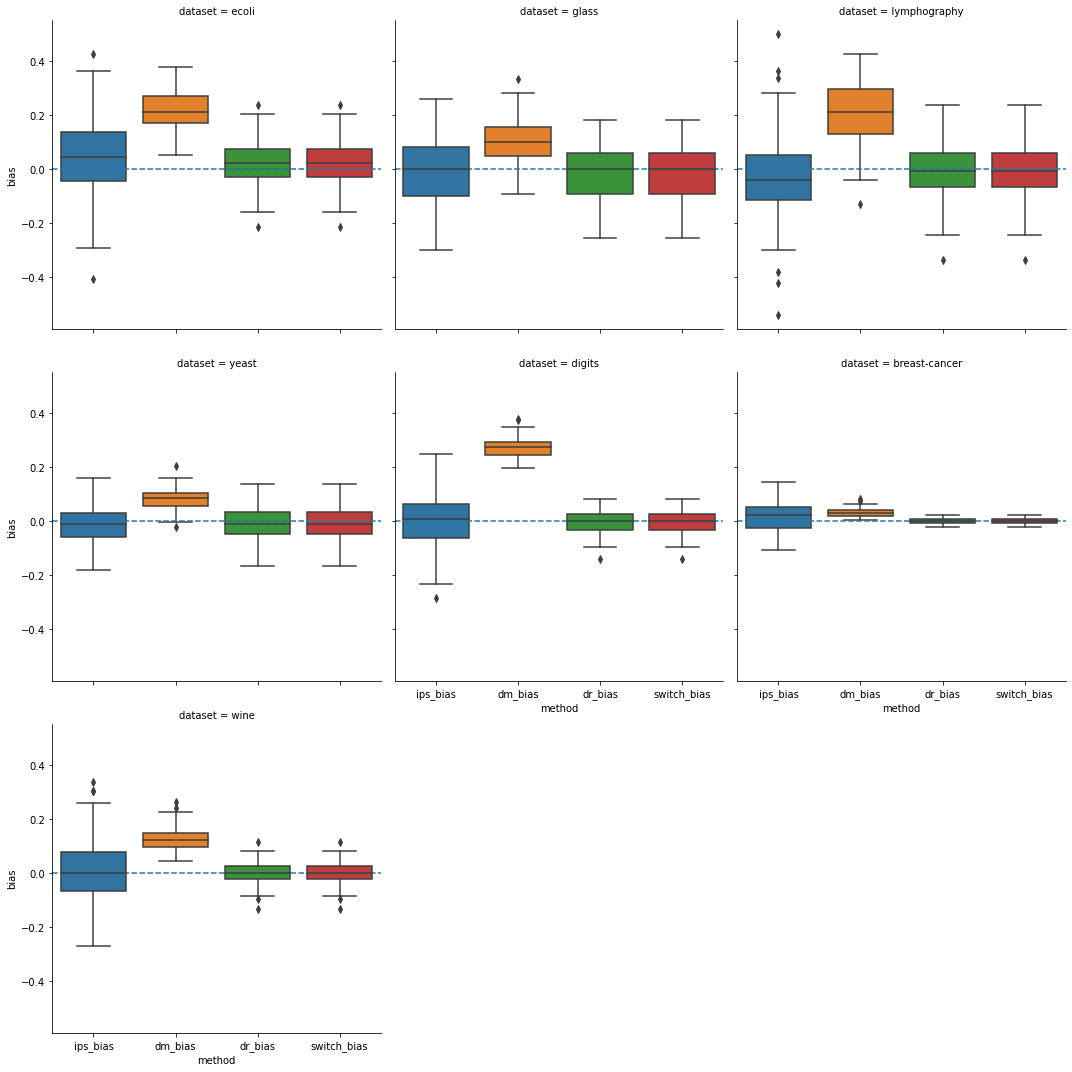

In [ ]:
cpe.plot_bias()

## Off-Policy Learning Estimators

In [ ]:
class EvaluationMetrics:
    
    def __init__(self) -> None:
        pass
    
    @staticmethod
    def error_rate(y_pred, y) -> float:
        er = 1 - np.mean(1 * (y_pred == y))
        
        return er

class BanditDataset(Dataset):
    
    def __init__(self, X, y, p0, r, y_idx):
        self.X = X
        self.y = y
        self.p0 = p0
        self.r = r
        self.y_idx = y_idx
        
    def __getitem__(self, index):
        return self.X[index], self.y[index], self.p0[index], self.r[index], self.y_idx[index]
        
    def __len__ (self):
        return len(self.X)
    
    
class LinearModel(torch.nn.Module):
    def __init__(self, n_features, n_actions):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(n_features, n_actions)

    def forward(self, x):
        xw_plus_b = self.linear(x)
        return xw_plus_b # batch size x n_actions
    
class NonLinearModel(torch.nn.Module):
    def __init__(self, n_features, n_actions, n_hidden=3):
        super().__init__()
        self.l1 = nn.Linear(n_features,n_hidden)
        self.l2 = nn.Linear(n_hidden,n_actions)
        
    def forward(self, x):
        return self.l2(F.relu(self.l1(x)))
   

class RewardPredictor(EvaluationMetrics):
    """
    Performs policy learning using by directly predicting the Reward as a function of covariates, 
    actions and their interaction. 
    
    References
    ----------
    
    .. [1] A. Swaminathan and T. Joachims, Batch Learning from Logged Bandit Feedback through 
           Counterfactual Risk Minimization, Journal of Machine Learning Research, 16(52),
           1731--1755, 2015.
    .. [2] A. Swaminathan and T. Joachims, The self-normalized estimator for counterfactual learning, 
           Advances in Neural Information Processing Systems, 28, 16(52), 3231--3239, 2015.
    .. [3] A. Swaminathan, T. Joachims, and M. de Rijke, Deep Learning with Logged Bandit Feedback, 
           International Conference on Learning Representations,  2018.
    
    """
        
    
    def __init__(self) -> None:
        pass
     
    def __repr__(self) -> str:
    
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def learn_policy(self, data, clf: str = 'LogisticRegression', **kwargs) -> None:
        """
        Parameters
        ----------
        data : STBT object
            This must be a Supervised to Bandit Transform (STBT) class with fitted 
            `generate_batch` method.
            
        clf : str, default: 'LogisticRegression'
        A sklearn classification estimator. Must be one of 'LogisticRegression', 
        'LogisticRegressionCV', 'RandomForestClassifier', or 'SVC'.
       
        **kwargs : Arguments passed to clf.
        Returns
        -------
        int.
          The predicted best policy.
        
        """    
    
        XY_train, lb_fit = create_interactions(data.X_train, data.y_train_logging)
        y_train_logging_u = np.unique(data.y_train_logging)
        self.train_pred_reward_arr = np.zeros(shape=[data.X_train.shape[0], len(y_train_logging_u)]) 
        self.test_pred_reward_arr = np.zeros(shape=[data.X_test.shape[0], len(y_train_logging_u)]) 
        m = eval(clf)(**kwargs).fit(XY_train, data.train_logging_reward)
        
        for i, yval in enumerate(y_train_logging_u):
           XY_train_yval, _ = create_interactions(data.X_train, np.repeat(yval, data.X_train.shape[0]), one_hot_labeler = lb_fit)
           XY_test_yval, _ = create_interactions(data.X_test, np.repeat(yval, data.X_test.shape[0]), one_hot_labeler = lb_fit)
           self.train_pred_reward_arr[:,i] = m.predict_proba(XY_train_yval)[:,1]
           self.test_pred_reward_arr[:,i] = m.predict_proba(XY_test_yval)[:,1]
             
        self.est_best_policy = np.array(y_train_logging_u[np.argmax(self.test_pred_reward_arr, axis=1)])
             
        return self
    
class OutcomeWeightedLearning(EvaluationMetrics):
    """
    Performs policy learning by transforming the learning problem into a 
    weighted multi-class classification problem. 
    
    
    References
    ----------
    
    .. [1] Y. Zhao, D. Zeng, A.J. Rush and M. R. Kosorok, Estimating Individualized Treatment 
           Rules Using Outcome Weighted Learning, Journal of the American Statistical Association, 
           107:499, 1106-1118, 2012, DOI: 10.1080/01621459.2012.695674.
    """
        
    def __init__(self) -> None:
        pass
     
    def __repr__(self) -> str:
    
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def learn_policy(self, data, clf: str = 'SVC', **kwargs) -> None:
    
        """
        Parameters
        ----------
        data : STBT object
            This must be a Supervised to Bandit Transform (STBT) class with fitted 
            `generate_batch` method.
            
        clf : str, default: 'SVC'
        A sklearn classification estimator. Must be one of 'LogisticRegression', 
        'LogisticRegressionCV', 'RandomForestClassifier', or 'SVC'.
       
        **kwargs : Arguments passed to clf.
        Returns
        -------
        int.
          The predicted best policy.
        
        """    
        
        wt = data.train_logging_reward / data.train_logging_prob
        
        if clf in ['SVC', 'RandomForestClassifier']:
            m = eval(clf)(**kwargs).fit(data.X_train, data.y_train_logging, sample_weight = wt)
        elif clf in ['LogisticRegression', 'LogisticRegressionCV']:
            m = eval(clf)(multi_class='multinomial', **kwargs).fit(data.X_train, data.y_train_logging, sample_weight = wt)
        
        self.est_best_policy = m.predict(data.X_test)
        
        return self
         

class VowpalWabbit(EvaluationMetrics):
    """
    Performs policy learning using Vowpal Wabbit. 
    
    Parameters
    ----------
    method : str, default: 'ips'
        The policy evaluation approach to optimize a policy. Vowpal Wabbit offers four 
        approaches to specify a contextual bandit approach:
            * Inverse Propensity Score: 'ips'
            * Doubly Robust: 'dr'
            * Direct Method: 'dm'
            * Multi Task Regression/Importance Weighted Regression: 'mtr' 
       
    References
    ----------
    
    .. [1] A. Bietti and A. Agarwal and J. Langford, A Contextual Bandit Bake-off, 
        arXiv preprint arXiv:1802.04064, 2018.
    
    """

    def __init__(self, method = 'dr') -> None:
        self.method = method
     
    def __repr__(self) -> str:
    
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def _train_vw(self, data):
        n_actions = len(np.unique(data.y_train_logging))
        vw = pyvw.vw(str("--cb_type") + " " +  self.method + " " + str(n_actions))
        for i in range(data.X_train.shape[0]):
            action = data.y_train_logging[i]
            cost = 1 - data.train_logging_reward[i] # input requires cost instead of reward
            probability = data.train_logging_prob[i]
            train_features_ls = list()
            for f in range(data.X_train.shape[1]):
                train_features_ls.append(str(data.X_train[i, f]))
                train_features = " ".join(train_features_ls)
            learn_example = str(action) + ":" + str(cost) + ":" + str(probability) + " | " + train_features
            vw.learn(learn_example) 
        return vw
    
    def _predict_vw(self, vw_object, data):
        test_features_ls = list()
        predictions = list()
        for i in range(data.X_test.shape[0]):
            for f in range(data.X_test.shape[1]):
                test_features_ls.append(str(data.X_test[i, f]))
                features = " ".join(test_features_ls)
            test_example = " | " + features
            pred = vw_object.predict(test_example) 
            predictions.append(pred)
        predictions = np.array(predictions)
    
        return predictions 
        
    
    def learn_policy(self, data) -> None:
        """
        Parameters
        ----------
        data : STBT object
            This must be a Supervised to Bandit Transform (STBT) class with fitted 
            `generate_batch` method.
            
        Returns
        -------
        int.
          The predicted best policy.
        
        """ 
        
        vw_fit = self._train_vw(data)
        self.est_best_policy = self._predict_vw(vw_fit, data)
        
        return self

class CounterfactualRiskMinimization(EvaluationMetrics):
    """
    Performs policy learning using the Counterfactual Risk Minimization 
    approach proposed in [1], and later refined in [2].
    
    Parameters
    ----------
    
    batch_size : int, default: 96
        The number of samples per batch to load 
    learning_rate : float, default: 0.01
        Stochastic gradient descent learning rate 
    weight_decay : float, default: 0.001
        L2 regularization on parameters
    lambda_ : float, default: 0.1
        Variance regularization. Penalty on the variance of the 
        learnt policy relative to the logging policy.
    self_normalize: bool, default: True
        Whether to normalize the IPS estimator. See [2].
    clipping: float, default: 100.
        Clipping the importance sample weights. See [1].
    verbose: bool, default: False
        Whether to print Poem Loss during training .
    
    References
    ----------
    
    .. [1] A. Swaminathan and T. Joachims, Batch Learning from Logged Bandit Feedback through 
            Counterfactual Risk Minimization, Journal of Machine Learning Research, 16(52),
            1731--1755, 2015.
    .. [2] A. Swaminathan and T. Joachims, The self-normalized estimator for counterfactual learning, 
            Advances in Neural Information Processing Systems, 28, 16(52), 3231--3239, 2015.
    .. [3] A. Swaminathan, T. Joachims, and M. de Rijke, Deep Learning with Logged Bandit Feedback, 
            International Conference on Learning Representations,  2018.
    
    """

    
    def __init__(self, batch_size: int = 96, learning_rate: float = 0.001, weight_decay: float = 0.001, 
                 lambda_: float = 0.5, self_normalize: bool = True, clipping : float = 100.,
                 verbose: bool = False) -> None:
        
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.lambda_ = lambda_
        self.self_normalize = self_normalize
        self.clipping = clipping 
        self.verbose = verbose
       
    def __repr__(self) -> str:
    
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def _poem_loss(self, pi, p0, r, y_idx, Lambda):
        
        if torch.sum(r) == 0: 
            r = torch.repeat_interleave(torch.tensor(1e-05, dtype=torch.float), len(r))
        
        bsz = pi.shape[0]
        softmax_pi = F.softmax(pi, dim=1)
        pi_i = softmax_pi.masked_select(y_idx)
        log_importance = torch.log(pi_i) - torch.log(p0) 
        importance = torch.exp(log_importance)    
        clip_importance_vals = torch.repeat_interleave(torch.tensor(self.clipping, dtype=torch.float), len(importance))
        importance = torch.min(clip_importance_vals, importance)
        off_policy_est = torch.mul(importance, r)
        # Eq.(8) in [2] 
        var_n = torch.sum(torch.mul(torch.pow(torch.sub(r, off_policy_est), 2), torch.pow(torch.div(pi_i, p0), 2)))
        var_d = torch.pow(torch.sum(torch.div(pi_i, p0)), 2)
        empirical_var = torch.div(var_n, var_d)
        if self.self_normalize:
            effective_sample_size = torch.sum(importance).detach() # turns off requires grad
            mean_off_policy_est = torch.div(torch.sum(off_policy_est), effective_sample_size) 
        else:
            mean_off_policy_est = torch.mean(off_policy_est)
        
        penalty = torch.mul(Lambda, torch.sqrt(torch.div(empirical_var, bsz)))
        loss = torch.mul(-1.0, mean_off_policy_est) + penalty
        
        return loss

   
    
    def learn_policy(self, model, data, epochs: int = 500) -> None:

        """
        Parameters
        ----------
        data : STBT object
            This must be a Supervised to Bandit Transform (STBT) class with fitted 
            `generate_batch` method.
        epochs : int, default 
            Number of training epochs.
            
        Returns
        -------
        int.
          The predicted best policy.
        
        """ 
        
        train_ds = BanditDataset(torch.from_numpy(data.X_train).float(),
                                 torch.from_numpy(data.y_train_logging).long(), 
                                 torch.from_numpy(data.train_logging_prob).float(), 
                                 torch.from_numpy(data.train_logging_reward).long(),
                                 torch.from_numpy(data.y_train_logging_idx).bool())
        
        
        n_features = train_ds.X.shape[1]
        actions = torch.unique(train_ds.y)
        n_actions = len(actions)
       
        train_dl = DataLoader(train_ds, self.batch_size)
        
        Model = model(n_features = n_features, n_actions = n_actions)
        
        optimizer = torch.optim.Adam(Model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)  
       
        for epoch in range(epochs):
            Model.train()
            train_epoch_loss = 0.
            for x_batch,y_batch,p0_batch,r_batch,y_idx_batch in train_dl:
                pi = Model(x_batch)
                loss = self._poem_loss(pi, p0_batch, r_batch, y_idx_batch, self.lambda_)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_epoch_loss += loss.item()
            if self.verbose:
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}: | Train Poem Loss: {train_epoch_loss/len(train_dl):.5f}')
            
        Model.eval()
        with torch.no_grad():
            X_test = torch.from_numpy(data.X_test).float()
            pred = Model(X_test)
            est_best_policy = actions[torch.argmax(pred, dim=1)]
            
        self.est_best_policy = est_best_policy.numpy()
         
        return self
    
    

class CounterfactualRiskMinimizationCV(CounterfactualRiskMinimization, EvaluationMetrics):
    """
    Tune variance penalty for Counterfactual Risk Minimization.
    
    Parameters
    ----------
    
    batch_size : int, default: 96
        The number of samples per batch to load 
    learning_rate : float, default: 0.01
        Stochastic gradient descent learning rate 
    weight_decay : float, default: 0.001
        L2 regularization on parameters
    self_normalize: bool, default: True
        Whether to normalize the IPS estimator. See [2].
    clipping: float, default: 100.
        Clipping the importance sample weights. See [1].
    verbose: bool, default: True
        Whether to print Poem Loss during training .
    lambda_ : 1D array, optional, defaults to grid of values 
        chosen in a logarithmic scale between 1e-4 and 1e+01.
    
    """
    
    def __init__(self, batch_size: int = 96, learning_rate: float = 0.001, weight_decay: float = 0.001, 
                 self_normalize: bool = True, clipping : float = 100., verbose: bool = False, 
                 lambda_: np.ndarray = None) -> None:
        
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.self_normalize = self_normalize
        self.clipping = clipping 
        self.verbose = verbose
        
        if lambda_ is None:
            self.lambda_ = 10 ** np.linspace(-4., 1., 10) # search in log scale
        else:
            self.lambda_= lambda_
                           
    def __repr__(self) -> str:
    
        items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
        return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
    def _get_params_min_loss(self, x):
        x = x.numpy()
        xmin_idx = np.unravel_index(x.argmin(), x.shape)
        l_best = self.lambda_[xmin_idx[0]]
          
        return l_best

    
    def learn_policy(self, model, data, valid_frac: float = 0.5, epochs: int = 500) -> None:
        """
        Parameters
        ----------
        data : STBT object
            This must be a Supervised to Bandit Transform (STBT) class with fitted 
            `generate_batch` method.
        valid_frac : float, default: 0.5
            Fraction of training data set for validation. Test data are not modified. 
        epochs : int, default: 500
            Number of training epochs.
            
        Returns
        -------
        int.
          The predicted best policy.
        
        """ 
        
        self.epochs = epochs
        self.valid_frac = valid_frac
        
        n_train_samples, n_features = data.X_train.shape
        idx_valid_samples = np.random.choice(range(n_train_samples), 
                                              size = int(np.floor(n_train_samples * valid_frac)), replace = False)
        
        train_ds = BanditDataset(torch.from_numpy(np.delete(data.X_train, idx_valid_samples, axis=0)).float(),
                                  torch.from_numpy(np.delete(data.y_train_logging, idx_valid_samples)).long(), 
                                  torch.from_numpy(np.delete(data.train_logging_prob, idx_valid_samples)).float(), 
                                  torch.from_numpy(np.delete(data.train_logging_reward, idx_valid_samples)).long(),
                                  torch.from_numpy(np.delete(data.y_train_logging_idx, idx_valid_samples, axis=0)).bool())
        
        
        valid_ds = BanditDataset(torch.from_numpy(data.X_train[idx_valid_samples, :]).float(),
                                  torch.from_numpy(data.y_train_logging[idx_valid_samples]).long(), 
                                  torch.from_numpy(data.train_logging_prob[idx_valid_samples]).float(), 
                                  torch.from_numpy(data.train_logging_reward[idx_valid_samples]).long(),
                                  torch.from_numpy(data.y_train_logging_idx[idx_valid_samples, :]).bool())
            
        y_train = np.delete(data.y_train, idx_valid_samples, axis=0)
        y_valid = data.y_train[idx_valid_samples]
        X_test = torch.from_numpy(data.X_test).float()
        
        actions = torch.unique(train_ds.y)
        n_actions = len(actions)
       
        train_dl = DataLoader(train_ds, self.batch_size)
        valid_dl = DataLoader(valid_ds, self.batch_size)
        
        Model = model(n_features=n_features, n_actions=n_actions)
        
        optimizer = torch.optim.Adam(Model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)  
           
        self.train_tot_loss_hist = torch.zeros(len(self.lambda_), epochs)   
        self.valid_tot_loss_hist = torch.zeros(len(self.lambda_), epochs)
        self.valid_acc = torch.zeros(len(self.lambda_), epochs) 
        self.train_acc = torch.zeros(len(self.lambda_), epochs) 
        self.test_acc = torch.zeros(len(self.lambda_), epochs) 
    
        for l_idx, l in enumerate(self.lambda_):
       
            for epoch in range(epochs):
                Model.train()
                train_epoch_loss = 0.
                for x_batch,y_batch,p0_batch,r_batch,y_idx_batch in train_dl:
                    pi = Model(x_batch)
                    loss = self._poem_loss(pi, p0_batch, r_batch, y_idx_batch, l)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    train_epoch_loss += loss.item()
                self.train_tot_loss_hist[l_idx, epoch] = train_epoch_loss/len(train_dl)
                if self.verbose:
                    if epoch % 100 == 0:
                        print(f'Epoch: {epoch} | Train Poem Loss: {train_epoch_loss/len(train_dl):.5f}')
                
                Model.eval()
                with torch.no_grad():
                    valid_tot_loss=0.
                    for x_batch,y_batch,p0_batch,r_batch,y_idx_batch in valid_dl:
                        pi = Model(x_batch)
                        valid_loss = self._poem_loss(pi, p0_batch, r_batch, y_idx_batch, l)
                        valid_tot_loss += valid_loss.item()
                self.valid_tot_loss_hist[l_idx, epoch] = valid_tot_loss/len(valid_dl)
                if self.verbose:
                      if epoch % 100 == 0:
                          print(f'Epoch: {epoch} | Valid Poem Loss: {valid_tot_loss/len(valid_dl):.5f}')
                
                pred_train = Model(train_ds.X)
                est_best_policy_train = actions[torch.argmax(pred_train, dim=1)]
                est_best_policy_train = est_best_policy_train.numpy()
                self.train_acc[l_idx, epoch] = self.error_rate(est_best_policy_train, y_train)
                pred_valid = Model(valid_ds.X)
                est_best_policy_valid = actions[torch.argmax(pred_valid, dim=1)]
                est_best_policy_valid = est_best_policy_valid.numpy()
                self.valid_acc[l_idx, epoch] = self.error_rate(est_best_policy_valid, y_valid)
                
                pred_test = Model(X_test)
                est_best_policy_test = actions[torch.argmax(pred_test, dim=1)]
                est_best_policy_test = est_best_policy_test.numpy()
                self.test_acc[l_idx, epoch] = self.error_rate(est_best_policy_test, data.y_test)
            
                          
        self.l_best = self._get_params_min_loss(self.valid_tot_loss_hist)
            
    
        
        crm = CounterfactualRiskMinimization(lambda_=self.l_best, batch_size = self.batch_size,
                                              learning_rate = self.learning_rate, weight_decay = self.weight_decay,
                                              clipping = self.clipping, self_normalize = self.self_normalize, verbose = self.verbose)
         
        crm.learn_policy(model=model, data=data, epochs=epochs) 
        self.est_best_policy = crm.est_best_policy
                
        return self
    
    def plot_cv_loss(self):
         
        train_loss_flatten = self.train_tot_loss_hist.T.flatten(1).numpy()
        valid_loss_flatten = self.valid_tot_loss_hist.T.flatten(1).numpy()
        
        train_acc_flatten =  self.train_acc.T.flatten(1).numpy()
        valid_acc_flatten = self.valid_acc.T.flatten(1).numpy()
        test_acc_flatten = self.test_acc.T.flatten(1).numpy()
        
        fig, axs = plt.subplots(2, 3)
        fs = 8
        
        for l_idx, l in enumerate(self.lambda_):
            axs[0, 0].plot(train_loss_flatten[:,l_idx], label = round(l, 4))
            axs[0, 1].plot(valid_loss_flatten[:,l_idx], label = round(l, 4))
            axs[1, 0].plot(train_acc_flatten[:,l_idx], label = round(l, 4))
            axs[1, 1].plot(valid_acc_flatten[:,l_idx], label = round(l, 4))
            axs[1, 2].plot(test_acc_flatten[:,l_idx], label = round(l, 4))
            
        axs[0, 0].set_title("Train: Poem Loss", fontsize=fs)
        axs[0, 1].set_title("Validation: Poem Loss", fontsize=fs)
        axs[1, 0].set_title("Train: Accuracy", fontsize=fs)
        axs[1, 1].set_title("Validation: Accuracy", fontsize=fs)
        axs[1, 2].set_title("Test: Accuracy", fontsize=fs)
        
        for i, ax in enumerate(axs.flat):
            if i < 2:
                ax.set_xlabel(xlabel='Epoch', fontsize=fs)
                ax.set_ylabel(ylabel='Loss', fontsize=fs)
            else:
                ax.set_xlabel(xlabel='Epoch', fontsize=fs)
                ax.set_ylabel(ylabel='Accuracy', fontsize=fs)
        fig.legend(self.lambda_, loc='upper right', fontsize=fs)

## Alternative using Doubly Robust (as opposed to the IPS estimator)

In [ ]:
# class CounterfactualRiskMinimization(EvaluationMetrics):
#     """
#     Performs policy learning using the Counterfactual Risk Minimization 
#     approach proposed in [1], and later refined in [2].
    
#     Parameters
#     ----------
#     batch_size : int, default: 96
#         The number of samples per batch to load 
#     learning_rate : float, default: 0.01
#         Stochastic gradient descent learning rate 
#     weight_decay : float, default: 0.001
#         L2 regularization on parameters
#     lambda_ : float, default: 0.1
#         Variance regularization. Penalty on the variance of the 
#         learnt policy relative to the logging policy.
#     self_normalize: bool, default: True
#         Whether to normalize the IPS estimator. See [2].
#     clipping: float, default: 100.
#         Clipping the importance sample weights. See [1].
#     verbose: bool, default: False
#         Whether to print Poem Loss during training .
    
#     References
#     ----------
    
#     .. [1] A. Swaminathan and T. Joachims, Batch Learning from Logged Bandit Feedback through 
#            Counterfactual Risk Minimization, Journal of Machine Learning Research, 16(52),
#            1731--1755, 2015.
#     .. [2] A. Swaminathan and T. Joachims, The self-normalized estimator for counterfactual learning, 
#            Advances in Neural Information Processing Systems, 28, 16(52), 3231--3239, 2015.
#     .. [3] A. Swaminathan, T. Joachims, and M. de Rijke, Deep Learning with Logged Bandit Feedback, 
#            International Conference on Learning Representations,  2018.
    
#     """

    
#     def __init__(self, batch_size: int = 96, learning_rate: float = 0.01, weight_decay: float = 0.001, 
#                  lambda_: float = 0.5, self_normalize: bool = True, clipping : float = 100.,
#                  verbose: bool = False) -> None:
#         self.batch_size = batch_size
#         self.learning_rate = learning_rate
#         self.weight_decay = weight_decay
#         self.lambda_ = lambda_
#         self.self_normalize = self_normalize
#         self.verbose = verbose
#         self.clipping = clipping 
     
#     def __repr__(self) -> str:
    
#         items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
#         return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
  
#     def _poem_loss(self, pi, p0, r, r_pred, y_idx, Lambda, self_normalize):
        
#         #if torch.sum(r) == 0: 
#         #    r = torch.repeat_interleave(torch.tensor(1e-05, dtype=torch.float), len(r))
        
        
#         bsz = pi.shape[0]
#         softmax_pi = F.softmax(pi, dim=1)
#         pi_i = softmax_pi.masked_select(y_idx)
#         r_pred_i = r_pred.masked_select(y_idx)
#         importance = torch.div(pi_i, p0) 
#         clip_importance_vals = torch.repeat_interleave(torch.tensor(self.clipping, dtype=torch.float), len(importance))
#         importance_clipped = torch.min(clip_importance_vals, importance)
#         reward_residual = torch.sub(r, r_pred_i)
#         weighted_reward_pred = torch.sum(torch.mul(softmax_pi, r_pred), dim=1)
#         off_policy_est = torch.add(torch.mul(importance_clipped, reward_residual), weighted_reward_pred)
#         empirical_var = torch.var(off_policy_est)
        
#         if self_normalize:
#             effective_sample_size = torch.sum(importance_clipped).detach() # turns off requires grad
#             sum_off_policy_est = torch.div(torch.sum(off_policy_est), effective_sample_size) 
#         else:
#             sum_off_policy_est = torch.sum(off_policy_est)
        
#         penalty = torch.mul(Lambda, torch.sqrt(torch.div(empirical_var, bsz)))
#         loss = torch.mul(-1.0, sum_off_policy_est) + penalty
             
#         return loss

    
#     def learn_policy(self, model, data, epochs: int = 500) -> None:

#         """
#         Parameters
#         ----------
#         data : STBT object
#             This must be a Supervised to Bandit Transform (STBT) class with fitted 
#             `generate_batch` method.
#         epochs : int, default 
#             Number of training epochs.
            
#         Returns
#         -------
#         int.
#           The predicted best policy.
        
#         """ 
        
#         rp = RewardPredictor().learn_policy(data=data, max_iter=1000)
        
#         train_ds = BanditDataset(torch.from_numpy(data.X_train).float(),
#                                  torch.from_numpy(data.y_train_logging).long(), 
#                                  torch.from_numpy(data.train_logging_prob).float(), 
#                                  torch.from_numpy(data.train_logging_reward).long(),
#                                  torch.from_numpy(data.y_train_logging_idx).bool(),
#                                  torch.from_numpy(rp.train_pred_reward_arr).float() 
#                                  )
        
        
#         n_features = train_ds.X.shape[1]
#         actions = torch.unique(train_ds.y)
#         n_actions = len(actions)
       
#         train_dl = DataLoader(train_ds, self.batch_size)
        
#         Model = model(n_features = n_features, n_actions = n_actions)
        
#         optimizer = torch.optim.SGD(Model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)  
        
#         for epoch in range(epochs):
#             Model.train()
#             train_epoch_loss = 0.
#             for x_batch, y_batch, p0_batch, r_batch, y_idx_batch, r_pred_batch in train_dl:
#                 pi = Model(x_batch)
#                 loss = self._poem_loss(pi, p0_batch, r_batch, r_pred_batch, y_idx_batch, self.lambda_, self.self_normalize)
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#                 train_epoch_loss += loss.item()
#             if self.verbose:
#                 print(f'Epoch {epoch}: | Train Poem Loss: {train_epoch_loss/len(train_dl):.5f}')
            
#         Model.eval()
#         with torch.no_grad():
#            X_test = torch.from_numpy(data.X_test).float()
#            pred = Model(X_test)
#            est_best_policy = actions[torch.argmax(pred, dim=1)]
            
#         self.est_best_policy = est_best_policy.numpy()
         
#         return self
    
    

# class CounterfactualRiskMinimizationCV(CounterfactualRiskMinimization, EvaluationMetrics):
#     """
#     Tune variance regularizer for Counterfactual Risk Minimization.
    
#     Parameters
#     ----------
    
#     batch_size : int, default: 96
#         The number of samples per batch to load 
#     learning_rate : float, default: 0.01
#         Stochastic gradient descent learning rate 
#     weight_decay : float, default: 0.001
#         L2 regularization on parameters
#     clipping: float, default: 100.
#         Clipping the importance sample weights. See [1].
#     self_normalize: bool, default: True
#         Whether to normalize the IPS estimator. See [2].
#     verbose: bool, default: True
#         Whether to print Poem Loss during training .
#     lambda_ : 1D array, optional, defaults to grid of values 
#         chosen in a logarithmic scale between 1e-4 and 1e+01.
    
#     """
    
#     def __init__(self, batch_size: int = 96, learning_rate: float = 0.01, weight_decay: float = 0.001, 
#                  clipping : float = 100., self_normalize: bool = True, verbose: bool = False, 
#                  lambda_: np.ndarray = None) -> None:
        
#         self.batch_size = batch_size
#         self.learning_rate = learning_rate
#         self.weight_decay = weight_decay
#         self.clipping = clipping 
#         self.self_normalize = self_normalize
#         self.verbose = verbose
        
#         if lambda_ is None:
#             self.lambda_ = 10 ** np.linspace(-4., 1., 10) # search in log scale
#         else:
#             self.lambda_= lambda_
                           
#     def __repr__(self) -> str:
    
#         items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
#         return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))
    
#     def _get_params_min_loss(self, x):
#         x = x.numpy()
#         xmin_idx = np.unravel_index(x.argmin(), x.shape)
#         l_best = self.lambda_[xmin_idx[0]]
          
#         return l_best

    
#     def learn_policy(self, model, data, valid_frac: float = 0.5, epochs: int = 500) -> None:
#         """
#         Parameters
#         ----------
#         data : STBT object
#             This must be a Supervised to Bandit Transform (STBT) class with fitted 
#             `generate_batch` method.
#         valid_frac : float, default: 0.5
#             Fraction of training data set for validation. Test data are not modified. 
#         epochs : int, default: 500
#             Number of training epochs.
            
#         Returns
#         -------
#         int.
#           The predicted best policy.
        
#         """ 
        
#         self.epochs = epochs
#         self.valid_frac = valid_frac
        
#         rp = RewardPredictor().learn_policy(data=data, max_iter=1000)
        
#         n_train_samples, n_features = data.X_train.shape
#         idx_valid_samples = np.random.choice(range(n_train_samples), 
#                                              size = int(np.floor(n_train_samples * valid_frac)), replace = False)
        
#         train_ds = BanditDataset(torch.from_numpy(np.delete(data.X_train, idx_valid_samples, axis=0)).float(),
#                                  torch.from_numpy(np.delete(data.y_train_logging, idx_valid_samples)).long(), 
#                                  torch.from_numpy(np.delete(data.train_logging_prob, idx_valid_samples)).float(), 
#                                  torch.from_numpy(np.delete(data.train_logging_reward, idx_valid_samples)).long(),
#                                  torch.from_numpy(np.delete(data.y_train_logging_idx, idx_valid_samples, axis=0)).bool(), 
#                                  torch.from_numpy(np.delete(rp.train_pred_reward_arr, idx_valid_samples, axis=0)).float()
#                                  )
        
        
#         valid_ds = BanditDataset(torch.from_numpy(data.X_train[idx_valid_samples, :]).float(),
#                                  torch.from_numpy(data.y_train_logging[idx_valid_samples]).long(), 
#                                  torch.from_numpy(data.train_logging_prob[idx_valid_samples]).float(), 
#                                  torch.from_numpy(data.train_logging_reward[idx_valid_samples]).long(),
#                                  torch.from_numpy(data.y_train_logging_idx[idx_valid_samples, :]).bool(),
#                                  torch.from_numpy(rp.train_pred_reward_arr[idx_valid_samples, :]).float()
#                                  )
            
#         y_train = np.delete(data.y_train, idx_valid_samples, axis=0)
#         y_valid = data.y_train[idx_valid_samples]
#         X_test = torch.from_numpy(data.X_test).float()
        
#         actions = torch.unique(train_ds.y)
#         n_actions = len(actions)
       
#         train_dl = DataLoader(train_ds, self.batch_size)
#         valid_dl = DataLoader(valid_ds, self.batch_size)
        
#         Model = model(n_features=n_features, n_actions=n_actions)
        
#         optimizer = torch.optim.SGD(Model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)  
           
#         self.train_tot_loss_hist = torch.zeros(len(self.lambda_), epochs)   
#         self.valid_tot_loss_hist = torch.zeros(len(self.lambda_), epochs)
#         self.valid_acc = torch.zeros(len(self.lambda_), epochs) 
#         self.train_acc = torch.zeros(len(self.lambda_), epochs) 
#         self.test_acc = torch.zeros(len(self.lambda_), epochs) 
    
#         for l_idx, l in enumerate(self.lambda_):
       
#             for epoch in range(epochs):
#                 Model.train()
#                 train_epoch_loss = 0.
#                 for x_batch, y_batch, p0_batch,r_batch,y_idx_batch,r_pred_batch in train_dl:
#                     pi = Model(x_batch)
#                     loss = self._poem_loss(pi, p0_batch, r_batch, r_pred_batch, y_idx_batch, l, self.self_normalize)
#                     loss.backward()
#                     optimizer.step()
#                     optimizer.zero_grad()
#                     train_epoch_loss += loss.item()
#                 self.train_tot_loss_hist[l_idx, epoch] = train_epoch_loss/len(train_dl)
#                 if self.verbose:
#                     print(f'Epoch: {epoch} | Train Poem Loss: {train_epoch_loss/len(train_dl):.5f}')
                
#                 Model.eval()
#                 with torch.no_grad():
#                     valid_tot_loss=0.
#                     for x_batch,y_batch,p0_batch,r_batch,y_idx_batch,r_pred_batch in valid_dl:
#                         pi = Model(x_batch)
#                         valid_loss = self._poem_loss(pi, p0_batch, r_batch, r_pred_batch, y_idx_batch, l, self.self_normalize)
#                         valid_tot_loss += valid_loss.item()
#                 self.valid_tot_loss_hist[l_idx, epoch] = valid_tot_loss/len(valid_dl)
#                 if self.verbose:
#                       print(f'Epoch: {epoch} | Valid Poem Loss: {valid_tot_loss/len(valid_dl):.5f}')
                
#                 pred_train = Model(train_ds.X)
#                 est_best_policy_train = actions[torch.argmax(pred_train, dim=1)]
#                 est_best_policy_train = est_best_policy_train.numpy()
#                 self.train_acc[l_idx, epoch] = self.error_rate(est_best_policy_train, y_train)
#                 pred_valid = Model(valid_ds.X)
#                 est_best_policy_valid = actions[torch.argmax(pred_valid, dim=1)]
#                 est_best_policy_valid = est_best_policy_valid.numpy()
#                 self.valid_acc[l_idx, epoch] = self.error_rate(est_best_policy_valid, y_valid)
                
#                 pred_test = Model(X_test)
#                 est_best_policy_test = actions[torch.argmax(pred_test, dim=1)]
#                 est_best_policy_test = est_best_policy_test.numpy()
#                 self.test_acc[l_idx, epoch] = self.error_rate(est_best_policy_test, data.y_test)
            
                          
#         self.l_best = self._get_params_min_loss(self.valid_tot_loss_hist)
            
    
        
#         crm = CounterfactualRiskMinimization(lambda_=self.l_best, batch_size = self.batch_size,
#                                              learning_rate = self.learning_rate, weight_decay = self.weight_decay,
#                                              clipping = self.clipping, self_normalize = self.self_normalize, verbose = self.verbose)
        
#         crm.learn_policy(model=model, data=data, epochs=epochs) 
#         self.est_best_policy = crm.est_best_policy
                
#         return self
    
#     def plot_cv_loss(self):
         
#         train_loss_flatten = self.train_tot_loss_hist.T.flatten(1).numpy()
#         valid_loss_flatten = self.valid_tot_loss_hist.T.flatten(1).numpy()
        
#         train_acc_flatten =  self.train_acc.T.flatten(1).numpy()
#         valid_acc_flatten = self.valid_acc.T.flatten(1).numpy()
#         test_acc_flatten = self.test_acc.T.flatten(1).numpy()
        
#         fig, axs = plt.subplots(2, 3)
#         fs = 8
        
#         for l_idx, l in enumerate(self.lambda_):
#             axs[0, 0].plot(train_loss_flatten[:,l_idx], label = round(l, 4))
#             axs[0, 1].plot(valid_loss_flatten[:,l_idx], label = round(l, 4))
#             axs[1, 0].plot(train_acc_flatten[:,l_idx], label = round(l, 4))
#             axs[1, 1].plot(valid_acc_flatten[:,l_idx], label = round(l, 4))
#             axs[1, 2].plot(test_acc_flatten[:,l_idx], label = round(l, 4))
            
#         axs[0, 0].set_title("Train: Poem Loss", fontsize=fs)
#         axs[0, 1].set_title("Validation: Poem Loss", fontsize=fs)
#         axs[1, 0].set_title("Train: Accuracy", fontsize=fs)
#         axs[1, 1].set_title("Validation: Accuracy", fontsize=fs)
#         axs[1, 2].set_title("Test: Accuracy", fontsize=fs)
        
#         for i, ax in enumerate(axs.flat):
#             if i < 2:
#                 ax.set_xlabel(xlabel='Epoch', fontsize=fs)
#                 ax.set_ylabel(ylabel='Loss', fontsize=fs)
#             else:
#                 ax.set_xlabel(xlabel='Epoch', fontsize=fs)
#                 ax.set_ylabel(ylabel='Accuracy', fontsize=fs)
#         fig.legend(self.lambda_, loc='upper right', fontsize=fs)

## Read data

In [ ]:
np.random.seed(1)
X, y = get_data(dataset= 'glass')

## Perform Supervised-to-Bandit Conversion
Performs Supervised to Bandit Conversion for classification datasets. This conversion is generally used to test the limits of counterfactual learning in a well-controlled environment.

Here, we take a supervised dataset with features x and labeled classes y, and simulate a bandit feedback data set from a logging policy. Basically, this involves: (i) simulating a stochastic logging policy, which may be uniform (logging_type='uniform'), or given as a function of covariates (logging_type = 'biased'), (ii) when the logging policy for a given observation equals the optimal policy (true label), a positive reward is observed.

In [ ]:
data = STBT(train_frac= 0.5, logging_type='biased').generate_batch(X, y, max_iter=1000)

## Skyline
Best possible error rate, assuming we have full feedback (this can only be tested from the simulation as in practice as we have bandit feedback)x.

In [ ]:
clf = LogisticRegressionCV(multi_class='multinomial', max_iter=2000).fit(data.X_train, data.y_train)
optimal_policy = clf.predict(data.X_test)
print("Skyline Error:", EvaluationMetrics.error_rate(optimal_policy, data.y_test))

Skyline Error: 0.30841121495327106


In [ ]:
## Reward Predictor (RP)
rp = RewardPredictor()
rp.learn_policy(data, max_iter=1000)
print("Reward Predictor Error:", rp.error_rate(rp.est_best_policy, data.y_test))

Reward Predictor Error: 0.7009345794392523


In [ ]:
## Outcome Weighted Learning (OWL)
owl = OutcomeWeightedLearning()
owl.learn_policy(data, clf = 'LogisticRegressionCV', max_iter=1000)
print("OWL-LR:", owl.error_rate(owl.est_best_policy, data.y_test))

OWL-LR: 0.7289719626168225


## Counterfactual Risk Minimization (CRM)

In [ ]:
crm = CounterfactualRiskMinimization(verbose=True, lambda_ = 1e-06)
crm.learn_policy(model=LinearModel, data=data, epochs = 2000)
print("CRM:", crm.error_rate(crm.est_best_policy, data.y_test))

Epoch 0: | Train Poem Loss: -0.10087
Epoch 100: | Train Poem Loss: -0.23397
Epoch 200: | Train Poem Loss: -0.37680
Epoch 300: | Train Poem Loss: -0.49386
Epoch 400: | Train Poem Loss: -0.54733
Epoch 500: | Train Poem Loss: -0.57395
Epoch 600: | Train Poem Loss: -0.58959
Epoch 700: | Train Poem Loss: -0.60032
Epoch 800: | Train Poem Loss: -0.60866
Epoch 900: | Train Poem Loss: -0.61578
Epoch 1000: | Train Poem Loss: -0.62223
Epoch 1100: | Train Poem Loss: -0.62831
Epoch 1200: | Train Poem Loss: -0.63413
Epoch 1300: | Train Poem Loss: -0.63967
Epoch 1400: | Train Poem Loss: -0.64488
Epoch 1500: | Train Poem Loss: -0.64968
Epoch 1600: | Train Poem Loss: -0.65401
Epoch 1700: | Train Poem Loss: -0.65786
Epoch 1800: | Train Poem Loss: -0.66122
Epoch 1900: | Train Poem Loss: -0.66412
CRM: 0.719626168224299


## Experiments

In [ ]:
## Params
B = 10 # Number of simulations
EPOCHS = 500
LOGGING_TYPE = 'biased'
MODEL = LinearModel
LAMBDA = 1e-06
DATASETS = ['ecoli', 'glass', 'lymphography', 'yeast', 'digits', 'breast-cancer', 'wine', 'letter-recognition']
dat = list()
skyline_error = list()
randomized_error = list()
reward_predictor_error = list()
owl_lrcv_error = list()
crm_error = list()

In [ ]:
for s in DATASETS:
    
    X, y = get_data(dataset=s)
    
    for b in range(B):
        if (b % 10) == 0:
            print("Sample: %d - Dataset: %s" % (b, s))
        
        d = STBT(logging_type = LOGGING_TYPE).generate_batch(X, y, max_iter=1000)
        dat.append(s)    
       
        skyline = LogisticRegression(multi_class='multinomial', max_iter=2000).fit(d.X_train, d.y_train)
        optimal_policy = skyline.predict(d.X_test)
        
        rp = RewardPredictor().learn_policy(data=d, max_iter=1000)
        erm_lrcv = OutcomeWeightedLearning().learn_policy(data=d, clf = 'LogisticRegressionCV', max_iter=1000)
        crm = CounterfactualRiskMinimization(lambda_=LAMBDA).learn_policy(model=MODEL, data=d, epochs=EPOCHS)     
        
        skyline_error.append(EvaluationMetrics.error_rate(optimal_policy, d.y_test))
        randomized_error.append(EvaluationMetrics.error_rate(d.y_test_logging, d.y_test))
        reward_predictor_error.append(rp.error_rate(rp.est_best_policy, d.y_test))
        owl_lrcv_error.append(erm_lrcv.error_rate(erm_lrcv.est_best_policy, d.y_test))
        crm_error.append(crm.error_rate(crm.est_best_policy, d.y_test))

Sample: 0 - Dataset: ecoli


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Sample: 0 - Dataset: glass
Sample: 0 - Dataset: lymphography
Sample: 0 - Dataset: yeast


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Sample: 0 - Dataset: digits
Sample: 0 - Dataset: breast-cancer
Sample: 0 - Dataset: wine
Sample: 0 - Dataset: letter-recognition


In [ ]:
res = pd.DataFrame.from_dict({'dataset':dat[1:], 'skyline_error': skyline_error, 'randomized_error':randomized_error, 'reward_predictor_error':reward_predictor_error,
                              'owl_lrcv_error':owl_lrcv_error, 'crm_error':crm_error})

res_summary = res.groupby(['dataset'], as_index=False).agg({
                            'skyline_error': ['mean','std'], 
                            'randomized_error': ['mean','std'], 
                            'reward_predictor_error': ['mean','std'],
                            'owl_lrcv_error': ['mean','std'],
                            'crm_error': ['mean','std']
                            })

res_summary

dataset skyline_error            ... owl_lrcv_error crm_error          
                               mean       std  ...            std      mean       std
0       breast-cancer      0.029123  0.009792  ...       0.162483  0.064561  0.051467
1              digits      0.036151  0.004104  ...       0.120459  0.426251  0.111795
2               ecoli      0.132937  0.018231  ...       0.178276  0.310714  0.080024
3               glass      0.401869  0.037642  ...       0.080883  0.629907  0.093996
4  letter-recognition      0.228200  0.004190  ...       0.030353  0.741250  0.028611
5        lymphography      0.168919  0.032638  ...       0.111444  0.410811  0.119722
6                wine      0.026966  0.022596  ...       0.104097  0.158427  0.094074
7               yeast      0.411456  0.011078  ...       0.062139  0.569946  0.045408

[8 rows x 11 columns]

## References
[1] A. Swaminathan and T. Joachims, Batch Learning from Logged Bandit Feedback through Counterfactual Risk Minimization, Journal of Machine Learning Research, 16(52), 1731--1755, 2015.

[2] A. Swaminathan and T. Joachims, The self-normalized estimator for counterfactual learning, Advances in Neural Information Processing Systems, 28, 16(52), 3231--3239, 2015.

[3] A. Swaminathan, T. Joachims, and M. de Rijke, Deep Learning with Logged Bandit Feedback, International Conference on Learning Representations, 2018.

[4] Y. Zhao, D. Zeng, A.J. Rush and M. R. Kosorok, Estimating Individualized Treatment Rules Using Outcome Weighted Learning, Journal of the American Statistical Association, 107:499, 1106-1118, 2012, DOI: 10.1080/01621459.2012.695674.

[5] Y. Wang, A. Agarwal and M. Dud'{\i}k, Optimal and Adaptive Off-policy Evaluation in Contextual Bandits, Proceedings of Machine Learning Research, 70, 3589--3597, 2017.

[6] M. Dudik and J. Langford and L. Li, Doubly Robust Policy Evaluation and Learning, CoRR, 2011. http://arxiv.org/abs/1103.4601

[7] K{"u}nzel, S., Sekhon, J., Bickel, P. and Yu, B., Metalearners for estimating heterogeneous treatment effects using machine learning, Proceedings of the National Academy of Sciences, 116(10), 4156--4165, 2019.

[8] Batch Learning from Bandit Feedback (BLBF). https://github.com/leoguelman/BLBF.